# Import data

In [1]:
import os

import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
from plotly.offline import iplot
import plotly.graph_objects as go

In [7]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 8.3 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.7/233.7 kB 4.0 MB/s eta 0:00:00a 0:00:01


In [2]:




from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA

import pmdarima as pm
from pmdarima.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

### TO DO: ADD REQUIREMENTS FILE -> do this in a conda environ


In [8]:
#!pip install pmdarima
#!pip install pandas
#!pip install seaborn
#!pip install statsmodels
!pip install plotly==5.8.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 7.8 MB/s eta 0:00:00:00:0100:01


In [3]:
sns.set(rc={'figure.figsize':(11, 4)})

In [4]:
ls

Untitled.ipynb   data/            load_data.ipynb


### Berlin temperature data

FILE FORMAT (MISSING VALUE CODE IS -9999):

* 01-06 SOUID: Source identifier
* 08-15 DATE : Date YYYYMMDD
* 17-21 TG   : mean temperature in 0.1 &#176;C
* 23-27 Q_TG : Quality code for TG (0='valid'; 1='suspect'; 9='missing')

In [7]:
date = ['DATE']

In [8]:
df = pd.read_csv('data/ECA_blended_Berlin/TG_STAID002759.txt', sep=',', skiprows=18, skipinitialspace=True, parse_dates=date)
#, parse_dates=date

### Berlin precipitation data

FILE FORMAT (MISSING VALUE CODE IS -9999):

* 01-06 SOUID: Source identifier
* 08-15 DATE : Date YYYYMMDD
* 17-21 RR   : precipitation amount in 0.1 mm
* 23-27 Q_RR : Quality code for RR (0='valid'; 1='suspect'; 9='missing')

In [9]:
print(os.getcwd())

/Users/ilonanietosvaara/Documents/Kurssit/spiced/spiced_projects/scikit-cilantro-student-code/week_07/project_07


In [10]:
df_prec = pd.read_csv('data/ECA_blended_Berlin_prec/RR_STAID002759.txt', sep=',', skiprows=18, skipinitialspace=True, parse_dates=date)
#, parse_dates=date

In [11]:
df_prec.head(2)

,SOUID,DATE,RR,Q_RR
0,127486,1876-01-01,90,0
1,127486,1876-01-02,8,0


In [12]:
df.head(3)

,SOUID,DATE,TG,Q_TG
0,127488,1876-01-01,22,0
1,127488,1876-01-02,25,0
2,127488,1876-01-03,3,0


In [13]:
df.columns

Index(['SOUID', 'DATE', 'TG', 'Q_TG'], dtype='object')

In [14]:
df.dtypes

SOUID             int64
DATE     datetime64[ns]
TG                int64
Q_TG              int64
dtype: object

## Check for stationarity - Augmented-Dicky-Fuller test

Source: https://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacf/notebook

In [15]:
# Unit root test
def check_stationarity(df):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(df)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items(): # pvalues are a dict that is the fourth indexed item
        print('\t%s: %.3f' % (key, value)) # prints p-values with 3 digit accuracy

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m") # prints stationary in green
    else:
        print("\x1b[31mNon-stationary\x1b[0m") # prints non-stationary in red


In [16]:
check_stationarity(df['TG'])

ADF Statistic: -12.079774
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary


In [19]:
adfuller(df['TG'])

(-12.07977412105668,
 2.246316026312432e-22,
 3,
 53442,
 {'1%': -3.430472368439155,
  '5%': -2.861594084413759,
  '10%': -2.5667987873313436},
 598854.6721821893)

## Train-test split

In [20]:
def train_test(df):
    df_train = df[:-365]
    df_test = df[-365:]
    return df_train, df_test

In [21]:
df, df_test = train_test(df)
df_prec, df_prec_test = train_test(df_prec)

In [22]:
ls

Untitled.ipynb   data/            load_data.ipynb


#### Save in CSV

In [23]:
df_test.to_csv('data/temp_test.csv')
df_prec_test.to_csv('data/prec_test.csv')

### Cleaning functions

In [24]:
# lower case all column names
def clean_cols(df):
    df.columns = map(str.lower, df.columns)
    return df

In [25]:
df = clean_cols(df)

In [26]:
# Crate year, month, day and weekday columns
def date_cols(df):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['weekday'] = df.index.weekday
    df['day'] = df.index.day
    return df

In [27]:
# make the datetime column to index
def date_to_index(df):
    df.set_index('date', inplace=True, drop=False)
    #df['time'] = df.index
    return df

In [28]:
# replace missing values coded as -9999 with np.nan
def missing_to_nan(df):
    df['tg'] = df['tg'].replace(-9999, np.nan)
    return df


### Call functions on Berlin precipitation data

In [29]:
df_prec = clean_cols(df_prec)

In [30]:
df_prec = date_to_index(df_prec)

In [31]:
df_prec = date_cols(df_prec)


In [32]:
df_prec.dtypes

souid               int64
date       datetime64[ns]
rr                  int64
q_rr                int64
year                int64
month               int64
weekday             int64
day                 int64
dtype: object

### Call cleaning functions on Berlin temperature data

In [33]:
df = clean_cols(df)

In [34]:
df = date_to_index(df)

In [35]:
df = date_cols(df)

In [36]:
df = missing_to_nan(df)

In [37]:
df.index.year

Int64Index([1876, 1876, 1876, 1876, 1876, 1876, 1876, 1876, 1876, 1876,
            ...
            2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021],
           dtype='int64', name='date', length=53081)

### Create celsius 1 column

In [38]:
df['temp'] = df.tg/10

NumExpr defaulting to 4 threads.


In [39]:
df.isna().sum()

souid        0
date         0
tg         195
q_tg         0
year         0
month        0
weekday      0
day          0
temp       195
dtype: int64

### Missing values

In [40]:
# Creating yearly averages
g = df.groupby(pd.Grouper(freq='Y')).mean()

In [41]:
# Find value counts for quality variable - when 9 --> missing 
df["q_tg"].value_counts()

0    52885
9      195
1        1
Name: q_tg, dtype: int64

In [42]:
# Find range of years with missing values
df['year'].loc[(df['q_tg']==9)].describe()[['min', 'max']]

min    1945.0
max    1945.0
Name: year, dtype: float64

In [ ]:
'''
# Finding the percentage of missing values 
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})

## compute null percentage of temperature per day)
nulls = (df.set_index(df.index)
         .groupby([df.index.day, pd.Grouper(freq='D')])['tg']
         .apply(lambda x: x.isnull().mean() * 100))
         
         
# pivot into tg vs time matrix
matrix = (nulls.reset_index(name='null (%)')
               .pivot(index='tg', columns='time', values='null (%)'))

'''

### Descriptive statistics

In [43]:
df.head(3)

,souid,date,tg,q_tg,year,month,weekday,day,temp
date,,,,,,,,,
1876-01-01,127488,1876-01-01,22.0,0,1876,1,5,1,2.2
1876-01-02,127488,1876-01-02,25.0,0,1876,1,6,2,2.5
1876-01-03,127488,1876-01-03,3.0,0,1876,1,0,3,0.3


In [44]:
#df.dtypes

In [45]:
df.shape

(53081, 9)

In [46]:
df.tail(3)

,souid,date,tg,q_tg,year,month,weekday,day,temp
date,,,,,,,,,
2021-04-28,111448,2021-04-28,109.0,0,2021,4,2,28,10.9
2021-04-29,111448,2021-04-29,113.0,0,2021,4,3,29,11.3
2021-04-30,111448,2021-04-30,83.0,0,2021,4,4,30,8.3


In [47]:
#df.describe()

In [48]:
# Accessing data for specific date
#df.loc['2017-08-10']

In [49]:
# Accessing data for 1900-1902
#df.loc['1900-01-20':'1910-01-22']

In [50]:
# 3655 days in this range
#df.loc['1900-01-20':'1910-01-22'].shape

In [51]:
#Data for the month of february 1900
#df.loc['1900-02']

In [52]:
#df.loc['1900-02'].describe()

In [53]:
#df.loc['2000-02'].describe()

### Create two datasets  
1. 1876 - 1944
2. 1946 - 2022

In [54]:
df_post = df.loc[(df.year>1945)]
df_pre = df.loc[(df.year < 1945)]

In [55]:
#df_post = pd.read_csv('data/df_post.csv', parse_dates=True)
#df_pre = pd.read_csv('data/df_pre.csv')

## Plot

In [56]:
df.dropna(inplace=True)

In [57]:
df.isna().sum()

souid      0
date       0
tg         0
q_tg       0
year       0
month      0
weekday    0
day        0
temp       0
dtype: int64

In [58]:
df.index.year

Int64Index([1876, 1876, 1876, 1876, 1876, 1876, 1876, 1876, 1876, 1876,
            ...
            2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021],
           dtype='int64', name='date', length=52886)

In [59]:
#Create yearly temp var
yearly_temp = df.resample("1y")[['temp']].mean()

In [60]:
df

,souid,date,tg,q_tg,year,month,weekday,day,temp
date,,,,,,,,,
1876-01-01,127488,1876-01-01,22.0,0,1876,1,5,1,2.2
1876-01-02,127488,1876-01-02,25.0,0,1876,1,6,2,2.5
1876-01-03,127488,1876-01-03,3.0,0,1876,1,0,3,0.3
1876-01-04,127488,1876-01-04,-58.0,0,1876,1,1,4,-5.8
1876-01-05,127488,1876-01-05,-98.0,0,1876,1,2,5,-9.8
...,...,...,...,...,...,...,...,...,...
2021-04-26,111448,2021-04-26,50.0,0,2021,4,0,26,5.0
2021-04-27,111448,2021-04-27,72.0,0,2021,4,1,27,7.2
2021-04-28,111448,2021-04-28,109.0,0,2021,4,2,28,10.9


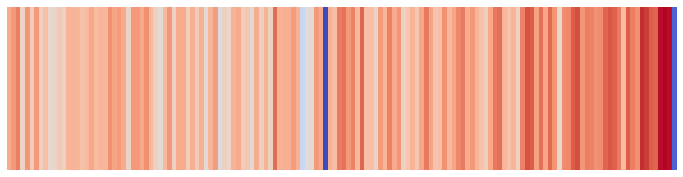

In [61]:
plt.figure(figsize=(12, 3))
sns.heatmap(yearly_temp.T, cmap='coolwarm', 
            xticklabels=[], yticklabels=[], # switch off all labels
            cbar=False
           )
_ = plt.xlabel(None)

In [62]:
# Plot temperature 
def simple_plot(df):
    df['temp'].plot(linewidth=0.5)

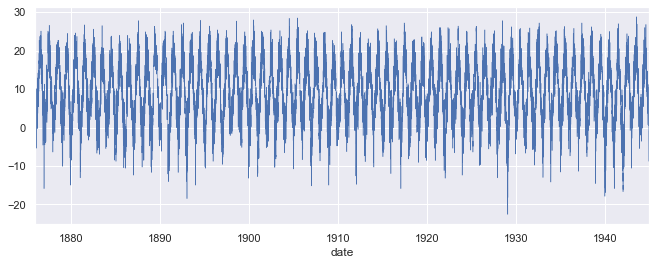

In [63]:
simple_plot(df_pre)

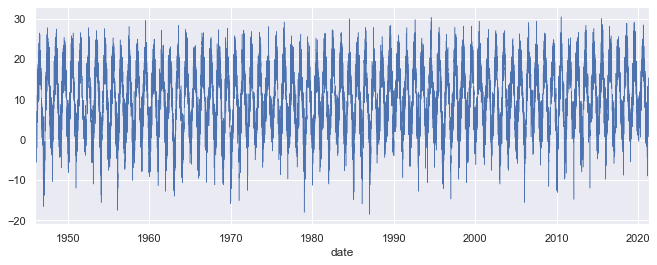

In [64]:
simple_plot(df_post)

### Plot specific years, months, days

In [65]:
def plot_year(df, year=2000):
    df['temp'].loc[(df.year == year)].plot(linewidth=0.5)
    
# Not really sure what this one does... 
def plot_month(df, month=6):
    df['temp'].loc[(df.month == month)].plot(linewidth=0.5)

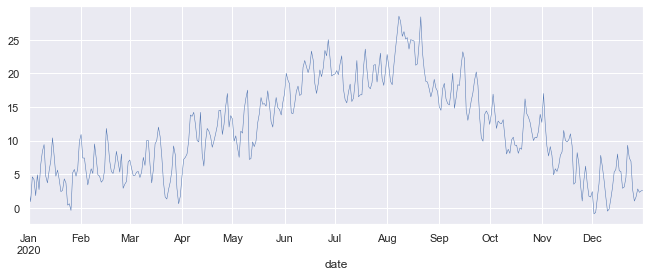

In [66]:
plot_year(df_post, 2020)


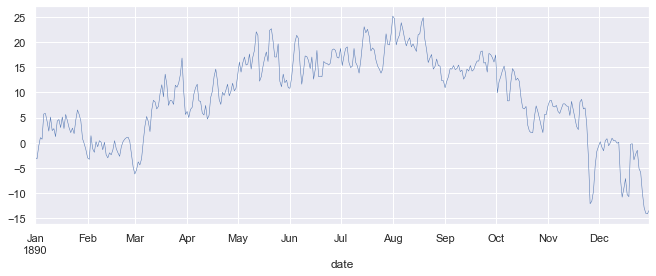

In [67]:
plot_year(df_pre, 1890)

# B. Remainder

In [68]:
df_post = df.loc[(df.year>1945)]
df_pre = df.loc[(df.year < 1945)]

### Timestep

In [69]:
def timestep(df):
    df['timestep'] = list(range(len(df)))
    return df

In [70]:
def X_and_y(df):
    X = df[['timestep']]
    y = df['temp']
    return X, y

In [71]:
def pred_trend(df, X):
    df['trend'] = m.predict(X)
    df[['temp', 'trend']].plot()
    return df

In [72]:
df_pre = timestep(df_pre)
df_post = timestep(df_post)

In [73]:
df_pre.head(2)

,souid,date,tg,q_tg,year,month,weekday,day,temp,timestep
date,,,,,,,,,,
1876-01-01,127488,1876-01-01,22.0,0,1876,1,5,1,2.2,0
1876-01-02,127488,1876-01-02,25.0,0,1876,1,6,2,2.5,1


## Pre 1945 data - predict seasonal trend

In [74]:
X, y = X_and_y(df_pre)

In [75]:
m = LinearRegression()

In [76]:
m.fit(X, y)

LinearRegression()

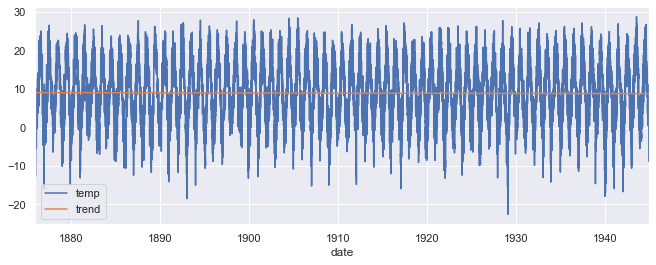

In [77]:
df_pre=pred_trend(df_pre, X)

## Post 1945 data - predict seasonal trend

In [78]:
X, y = X_and_y(df_post)


In [79]:
m.fit(X, y)

LinearRegression()

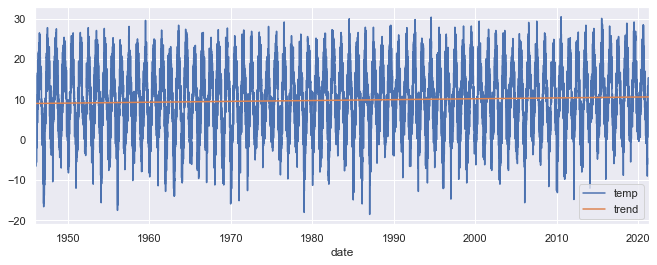

In [80]:
df_post = pred_trend(df_post, X)

### Trend plots for pre- and post-1945 data

<AxesSubplot:title={'center':'Trend of mean temperature, 1876-2022'}, xlabel='date'>

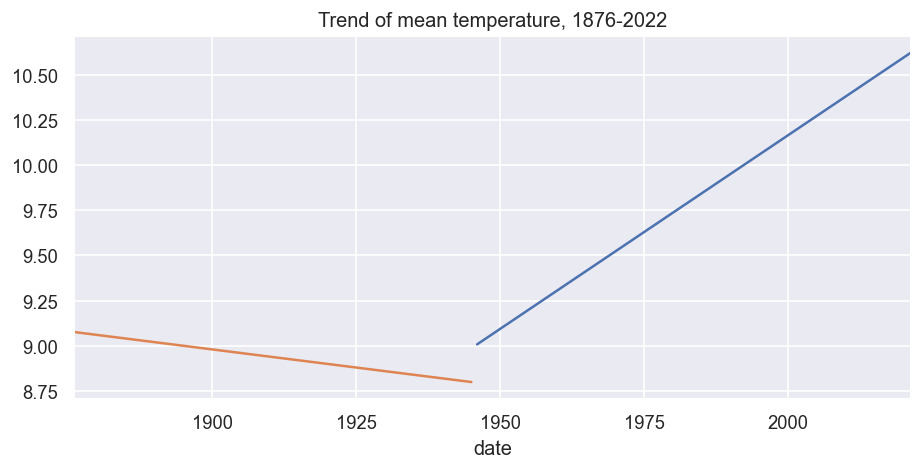

In [81]:
plt.rcParams.update({'figure.figsize':(9,4), 'figure.dpi':120})
df_post['trend'].plot(title = 'Trend of mean temperature, 1876-2022')
df_pre['trend'].plot()

In [82]:
#df_pre.groupby(df_pre.index.day)['temp'].mean().plot()

### Mean monthly temperature

In [83]:
# df_pre.groupby(df_pre.index.month)['temp'].mean().plot()

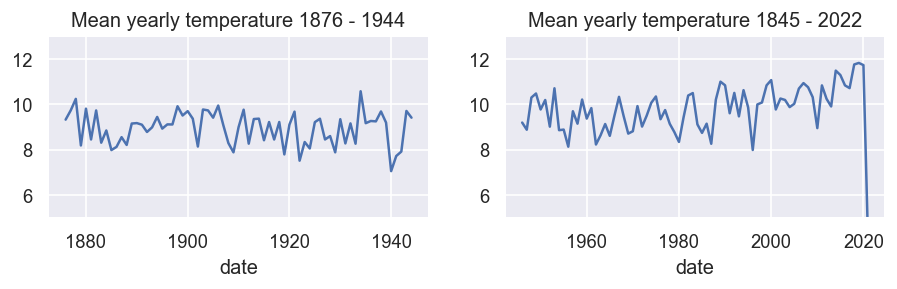

In [84]:
plt.rcParams.update({'figure.figsize':(9,2), 'figure.dpi':120})
fig, ax = plt.subplots(1,2)
figsize = [6, 12]
ax[0].set_ylim(5,13)
ax[1].set_ylim(5,13)
df_pre.groupby(df_pre.index.year)['temp'].mean().plot(title= 'Mean yearly temperature 1876 - 1944', ax = ax[0])
df_post.groupby(df_post.index.year)['temp'].mean().plot(title= 'Mean yearly temperature 1845 - 2022', ax = ax[1])
plt.show()

## Functions to get the remainder


In [85]:
# Define X and y

def X_and_y(df):
    X = df[['timestep']]
    y = df['temp']
    return X, y


In [86]:
# Get monthly seasonal dummies

def seasonal_dum(df):
    seasonal_dummies = pd.get_dummies(df.index.month, drop_first=True, prefix='month').set_index(df.index)
    df = df.join(seasonal_dummies)
    return df
    

In [87]:
# Place monthly dummies as the independent var

def get_X_months(df):
    X = df[df.columns[df.columns.isin(['timestep', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12'])]]
    return X

In [88]:
# Get min date

def min_date(df):
    df.index.min()
    min_date = str(df.index.min())
    min_date = min_date[0:10]
    return min_date

In [89]:
# Define from which point to get predictions and plots from
plt.rcParams.update({'figure.figsize':(9,6), 'figure.dpi':120})

def get_remainder(df, start = min_date, plot=False):
    df = df.loc[start:]
    length = len(df)
    X = get_X_months(df)
    y_new = y[-length:]
    m.fit(X, y_new)
    df['trend_seasonal'] = m.predict(X)
    df['remainder'] = df['temp'] - df['trend_seasonal']
    if plot==True:
        fig,ax =  plt.subplots(2,1) 
        ax[0].set_ylim(-10,25)
        ax[1].set_ylim(-10,25)
        df[['temp', 'trend_seasonal']].plot(title = 'Temperature and seasonal trend', ax = ax[0])
        df['remainder'].plot(title = 'Remainder', ax = ax[1])
        plt.show()
    return df


In [90]:
min_date_post = min_date(df_post)
min_date_pre = min_date(df_pre)

In [91]:
min_date_post, min_date_pre

('1946-01-01', '1876-01-01')

## Call functions on df_post (post 1945 data)

In [92]:
X, y = X_and_y(df_post)

In [93]:
df_post = seasonal_dum(df_post)

In [94]:
X = get_X_months(df_post)

In [95]:
#df_post = get_remainder(df_post, '2015-05-01' , plot=True)

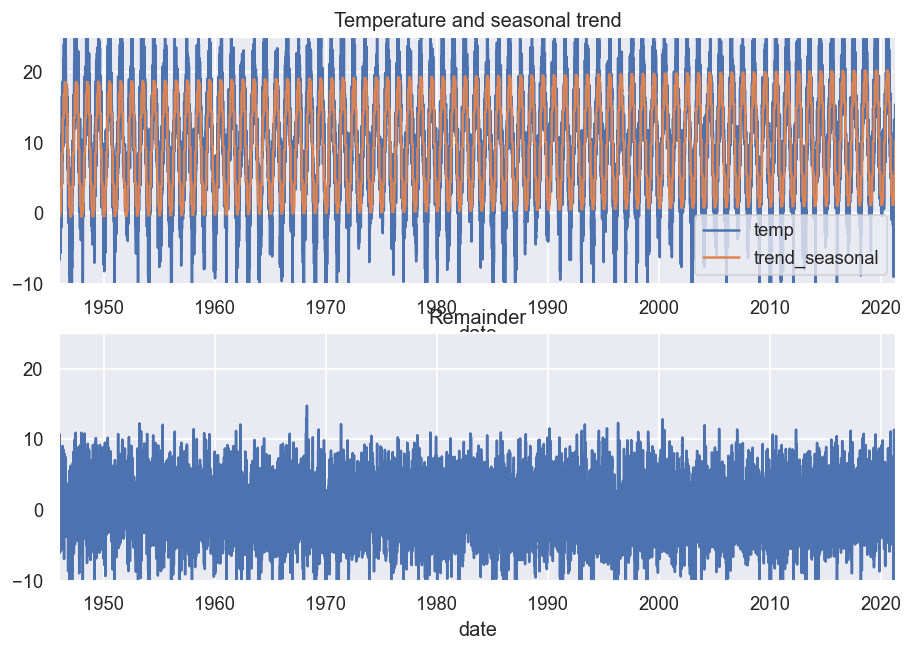

In [96]:
df_post= get_remainder(df_post, min_date_post, plot=True)

## Call functions on df_post (post 1945 data)

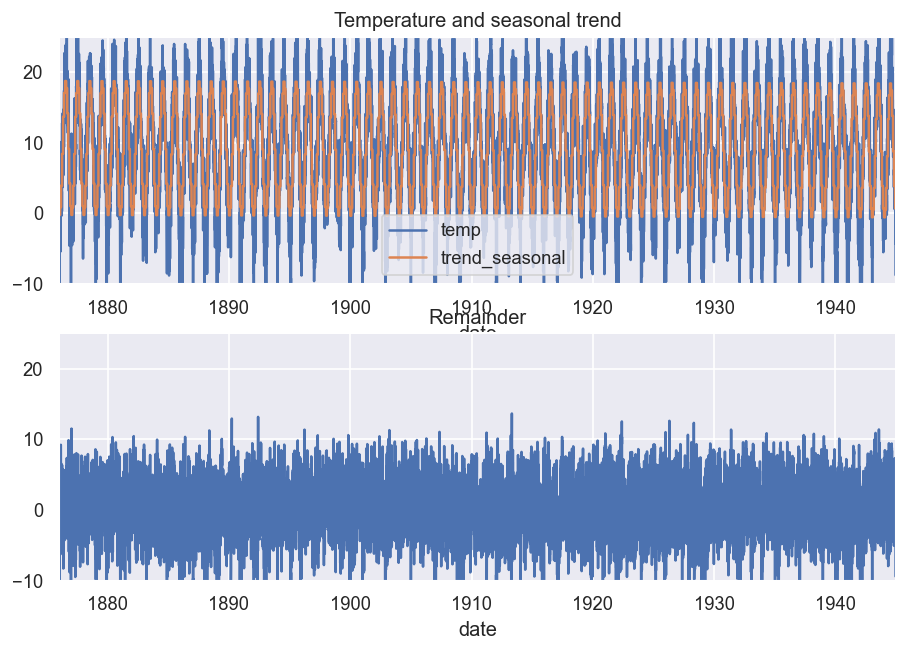

In [97]:
X, y = X_and_y(df_pre)

df_pre = seasonal_dum(df_pre)

X = get_X_months(df_pre)

df_pre = get_remainder(df_pre, min_date_pre, plot=True)

## Save pre and post 1945 data

In [98]:
df_post.to_csv('data/df_post.csv', index_label =False)
df_pre.to_csv('data/df_pre.csv', index_label =False)

In [99]:
def save_read_csv(df, name):
    df.to_csv(f'data/{name}.csv', index_label =False)
    df = pd.read_csv(f'data/{name}.csv')
    df.index = pd.to_datetime(df.index)
    print(df.index.dtype)
    return df
    

In [100]:
df_post = save_read_csv(df_post, 'df_post')
df_pre = save_read_csv(df_pre, 'df_pre')

datetime64[ns]
datetime64[ns]


In [101]:
ls -a 'data/'

./                       ECA_blended_Berlin_prec/ post_remainder.csv
../                      ECA_blended_Turku/       pre_remainder.csv
.DS_Store                df_post.csv              prec_test.csv
ECA_blended_Berlin/      df_pre.csv               temp_test.csv


## Save remainder in csv

In [102]:
df_post['remainder'].to_csv('data/post_remainder.csv')
df_pre['remainder'].to_csv('data/pre_remainder.csv')

**Conditions of stationarity:**

- constant mean
 - constant standard deviation
- no seasonality

Non-stationary time series can be transformed into stationary time series data by:

- taking first (or higher order) differences to stabilize the mean
- transformations (e.g. log) can help to stabilize the variance
- taking out seasonality

“A stationary time series process […] is said to be weakly dependent if xt and xt-h are “almost independent” as h” goes to infinity. “In other words, as the variables get farther apart in time, the correlation between them becomes smaller and smaller.” - Introductory Econometrics - Wooldridge, J.

## Complex seasonality removal

If the data are measurements of a natural phenomenon (e.g., temperature), we can probably safely ignore any weekly seasonality.


Source: https://otexts.com/fpp2/complexseasonality.html

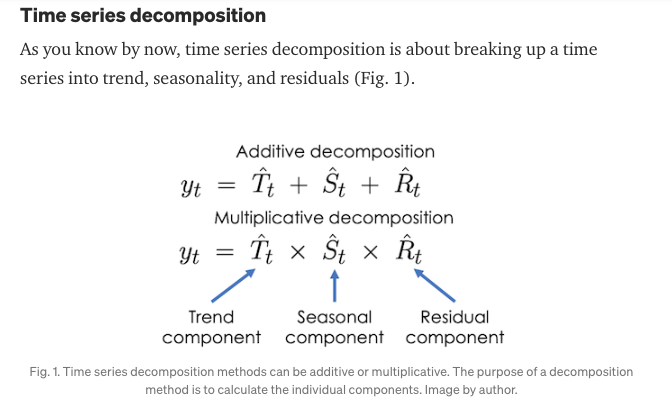

**Single-seasonal component**

Some commonly used methods for time series decomposition include:

A naive method where we apply a moving average to extract a trend and take averages of a seasonal index (e.g., month) to extract seasonality;
Seasonal-Trend decomposition using Loess (STL) [2];
X-13-ARIMA-SEATS [3].

These methods are designed to extract a single seasonal component from a time series.

**Multiple seasonal components**

Methods that can extract multiple seasonal components include Prophet [4], TBATS [5], and STR [6]. Prophet and TBATS infer the seasonal components as part of training a forecasting model. MSTL instead directly focuses on just decomposing a time series. Later we’ll see that MSTL outperforms these other methods on a set of benchmark time series [1]. With that, let’s dive into the details of MSTL.

Source: https://towardsdatascience.com/multi-seasonal-time-series-decomposition-using-mstl-in-python-136630e67530

## MSTL - Multiple Seasonal Trend decomposition using LOESS

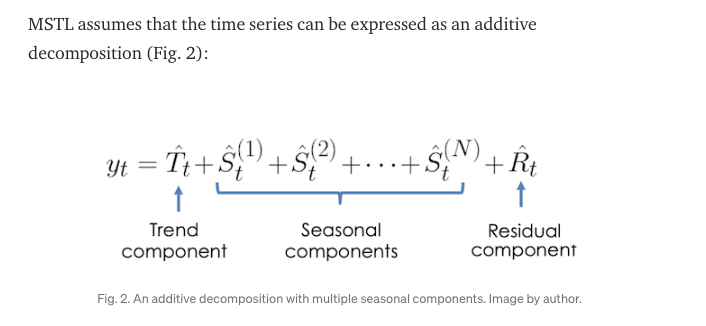

## Lags (from here only for post 1945 data) 

In [103]:
# Add lag feature — for modeling remainder
def add_lag(df):
    df['lag1'] = df['remainder'].shift(1)
    return df

In [104]:
df_post = add_lag(df_post)


In [105]:
df_post['timestep'] = df_post['timestep'] +1

In [106]:
df_post.dropna(inplace=True)

In [107]:
def X_full_y_full(df):
    X_full = df.drop(['tg', 'temp', 'q_tg', 'month', 'weekday', 'year', 'day', 'date', 'souid', 'trend_seasonal', 'remainder', 'trend'], axis=1)
    y_full = df['temp']
    return X_full, y_full

In [108]:
X_full, y_full = X_full_y_full(df_post)

In [109]:
y_full.dtype

dtype('float64')

In [110]:
m_full = LinearRegression()
m_full.fit(X_full, y_full)

LinearRegression()

In [111]:
df_post['full_model'] = m_full.predict(X_full)


<AxesSubplot:>

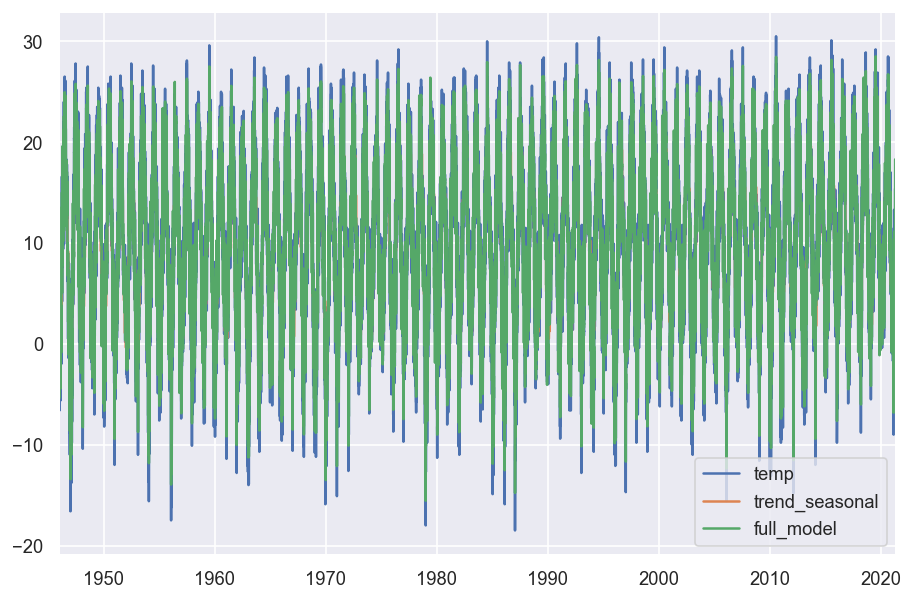

In [112]:
df_post[['temp', 'trend_seasonal', 'full_model']].plot()

In [113]:
df_post['remainder_full_model'] = df_post['temp'] - df_post['full_model']

<AxesSubplot:>

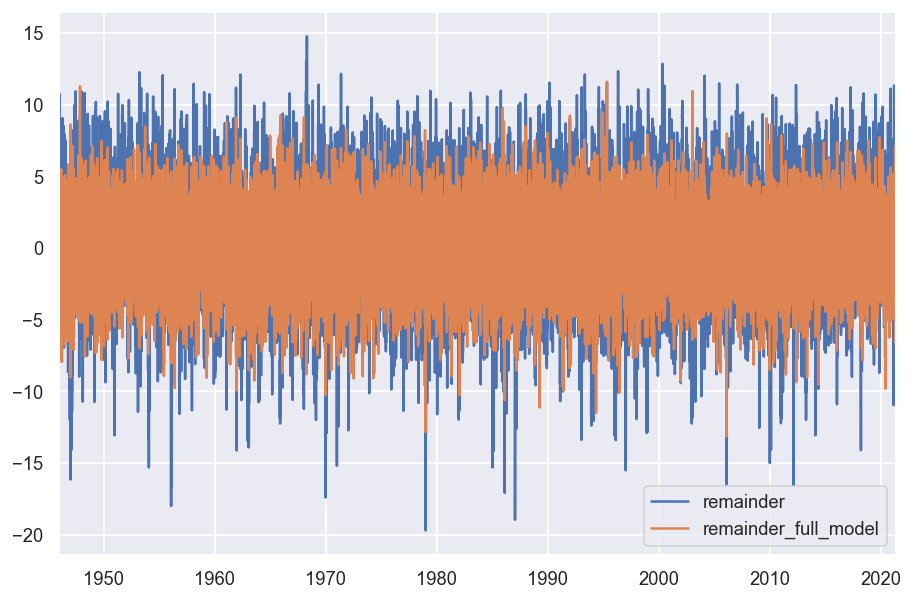

In [114]:
df_post[['remainder', 'remainder_full_model']].plot()

### Compare models - BIC and AIC

In [115]:
# Summary method in Statsmodels 
# or for BIC - select_models method -- only for your target variable (series?)

## AR model

In [116]:
plt.rcParams['figure.figsize'] = (14,6)

In [117]:
#remainder = df_post['remainder']
df_post['pred_var'] = df_post['remainder']

### Plot ACF and PACF

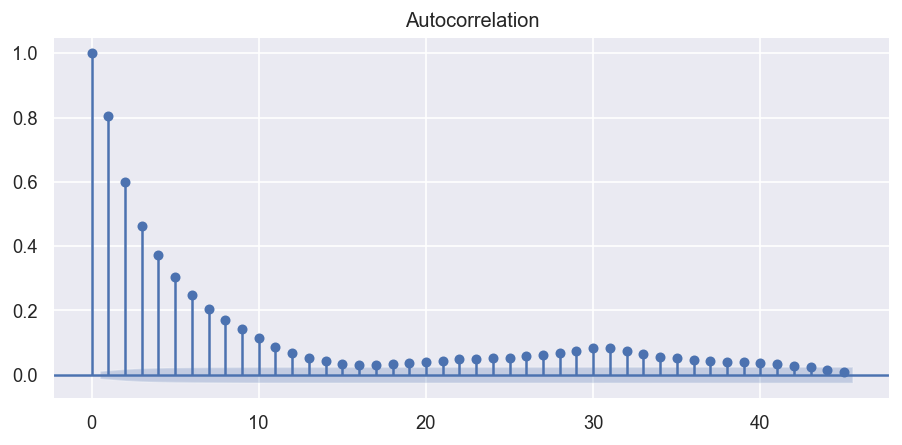

In [118]:
# ACF
plt.rcParams.update({'figure.figsize':(9,4), 'figure.dpi':120})

plot_acf(df_post['pred_var']);

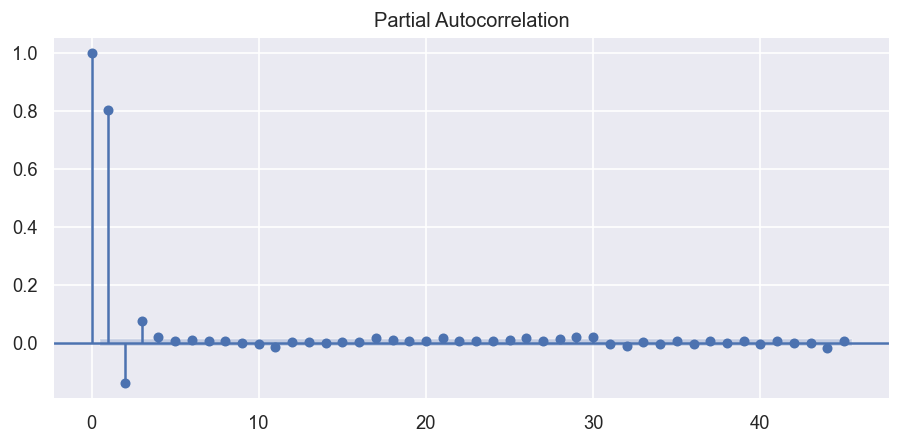

In [119]:
plot_pacf(df_post['pred_var']);

## Conclusion of ACF and PACF

- The ACF shows a slow decay
- The PACF shows a drop after a certain lag /// OR an exponential and slow decay?? 

--> Make both Arima and AR(p) just in case - not sure how to interpret

### Number of lags based on Bayesian information criteria

In [120]:
selected_order = ar_select_order(df_post['remainder'], maxlag=12)

In [121]:
selected_order.bic

{(1, 2, 3): 1.6788322098477624,
 (1, 2, 3, 4): 1.6788409810745384,
 (1, 2, 3, 4, 5): 1.6791628580888278,
 (1, 2, 3, 4, 5, 6): 1.6794707497802606,
 (1, 2, 3, 4, 5, 6, 7): 1.6797909464005543,
 (1, 2, 3, 4, 5, 6, 7, 8): 1.6801399471337481,
 (1, 2, 3, 4, 5, 6, 7, 8, 9): 1.6805091884776735,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10): 1.6808559004467738,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11): 1.6810421808725589,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12): 1.6814040380579796,
 (1, 2): 1.6840078385975221,
 (1,): 1.7027750973640663,
 0: 2.7476975117483216}

In [122]:
selected_order.ar_lags

array([1, 2, 3])

## Run AR(3) model

In [123]:
ar_model = AutoReg(endog=df_post['temp'], lags=3).fit()

In [124]:
df_post['prediction_sm']= ar_model.predict()

<AxesSubplot:>

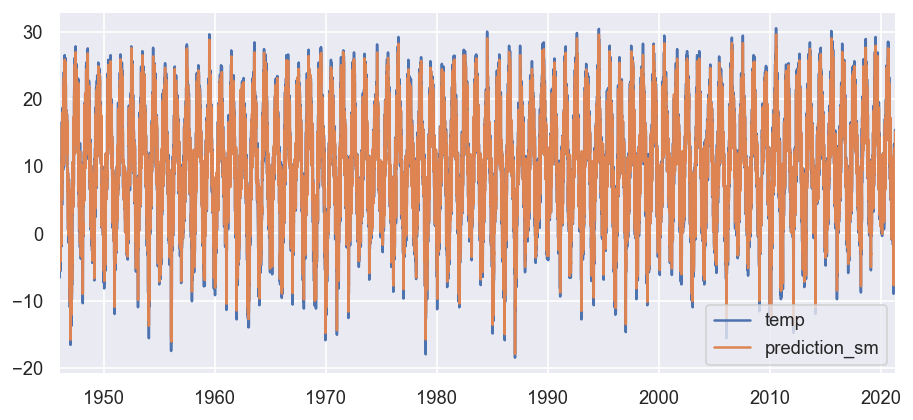

In [125]:
df_post[['temp', 'prediction_sm']].plot()

In [126]:
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                   temp   No. Observations:                27513
Model:                     AutoReg(3)   Log Likelihood              -62217.576
Method:               Conditional MLE   S.D. of innovations              2.323
Date:                Wed, 07 Sep 2022   AIC                              1.686
Time:                        17:23:16   BIC                              1.687
Sample:                    01-05-1946   HQIC                             1.686
                         - 04-30-2021                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3939      0.023     17.414      0.000       0.350       0.438
temp.L1        1.0191      0.006    171.374      0.000       1.007       1.031
temp.L2       -0.2242      0.008    -26.549      0.000      -0.241      -0.208
temp.L3        0.1650      0.006     27.745      0.000       0.153       0.177
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0373           -0.0000j            1.0373           -0.0000
AR.2            0.1608           -2.4120j            2.4174           -0.2394
AR.3            0.1608           +2.4120j            2.4174            0.2394
-----------------------------------------------------------------------------
"""

## Arima model - 2 year period


"A nonseasonal ARIMA model is classified as an "ARIMA(p,d,q)" model, where:

- p is the number of autoregressive terms,
- d is the number of nonseasonal differences needed for stationarity, and
- q is the number of lagged forecast errors in the prediction equation.

The forecasting equation is constructed as follows.  First, let y denote the dth difference of Y, which means:"

If d=0:  $y_t  =  Y_t$

If d=1:  $y_t  =  Yt - Y_{t-1}$

If d=2:  $y_t  =  (Y_t - Y_{t-1}) - (Y_{t-1} - Y_{t-2})  =  Y_t - 2Y_{t-1} + Y_{t-2}$

### When to use ARIMA based on ACF and PACF: 

The ACF and PACF plots should be considered together to define the process. 

**For the AR process**: the ACF plot will gradually decrease and simultaneously the PACF should have a sharp drop after p significant lags. 

**For the MA process**: the ACF should show a sharp drop after a certain q number of lags while PACF should show a geometric or gradual decreasing trend. 

**For the ARMA (or ARIMA):** if both ACF and PACF plots demonstrate a gradual decreasing pattern.

Source: https://towardsdatascience.com/identifying-ar-and-ma-terms-using-acf-and-pacf-plots-in-time-series-forecasting-ccb9fd073db8

In [127]:
df_2019 =  df_post[-730:]

<AxesSubplot:title={'center':'Daily temperature in celsius June 2019- April 2022'}>

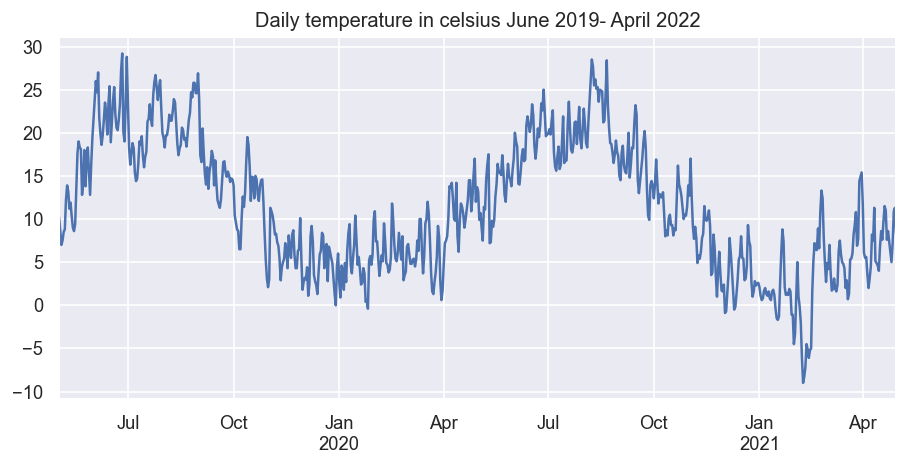

In [128]:
df_2019['temp'].plot(title = 'Daily temperature in celsius June 2019- April 2022')

### Calc remainder for 2-year series

In [129]:
min(df_2019.index)

Timestamp('2019-05-02 00:00:00')

In [130]:
def X_and_y(df):
    X = df[['timestep']]
    y = df['temp']
    return X, y

In [131]:
X, y = X_and_y(df_2019)

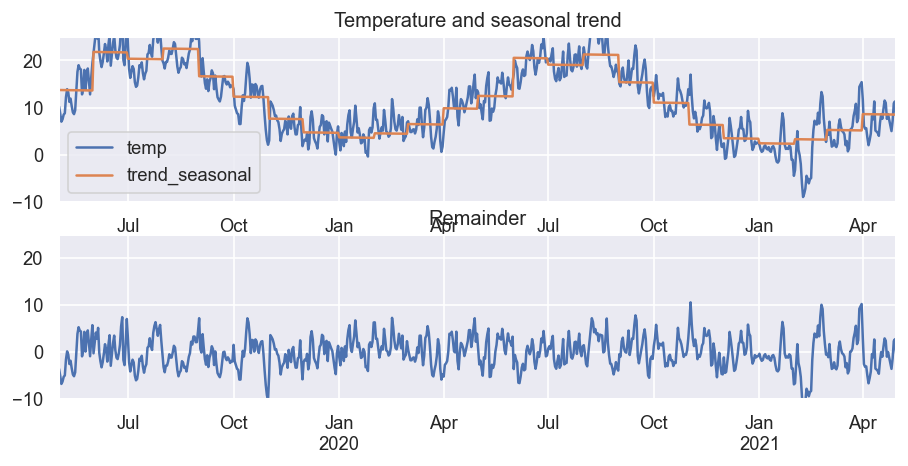

In [132]:
df_2019 = get_remainder(df_2019, '2019-05-02' , plot=True)

ADF Statistic: -1.508350
p-value: 0.529377
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
Non-stationary


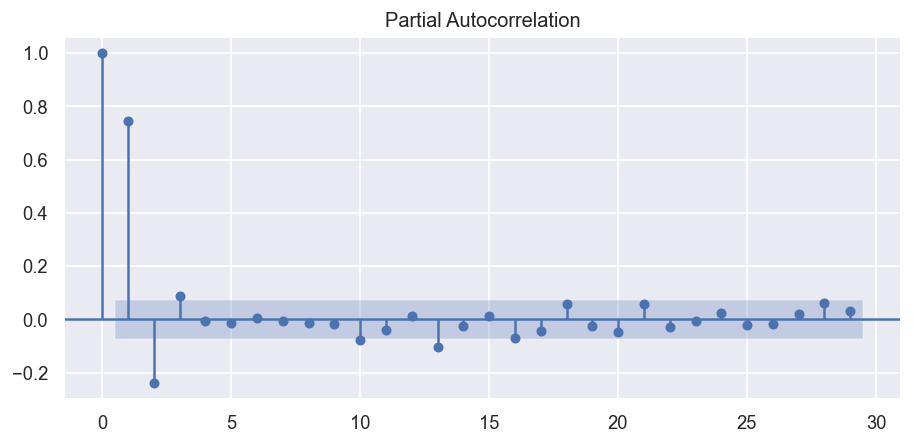

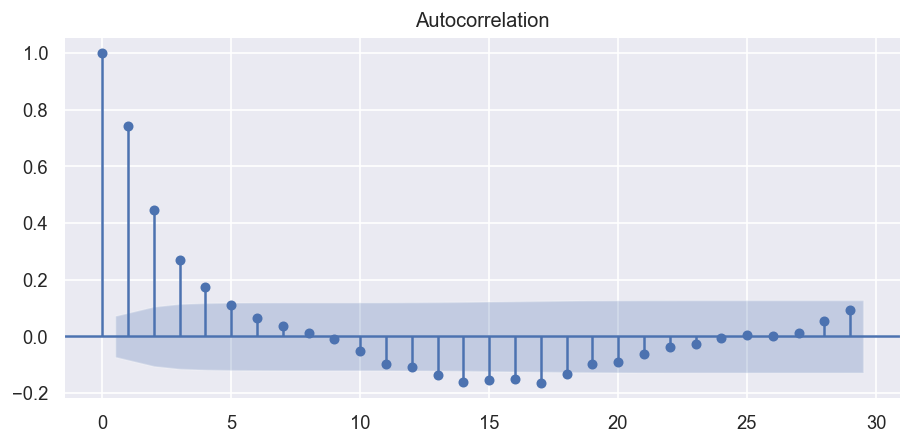

In [133]:
# Determine values of p, q and i

# value of p
plot_pacf(df_2019['remainder'][1:])

# value of q
plot_acf(df_2019['remainder'][1:])

# value of d
check_stationarity(df_2019['temp'])


In [134]:
selected_order_2 = ar_select_order(df_2019['remainder'], maxlag=12)

In [135]:
selected_order_2.bic

{(1, 2): 1.5714265670099332,
 (1, 2, 3): 1.5726379081303783,
 (1, 2, 3, 4): 1.581774116262752,
 (1, 2, 3, 4, 5): 1.5906962749584452,
 (1, 2, 3, 4, 5, 6): 1.5998460531155039,
 (1, 2, 3, 4, 5, 6, 7): 1.6089335625891235,
 (1, 2, 3, 4, 5, 6, 7, 8): 1.6178446240670774,
 (1,): 1.6198679548200292,
 (1, 2, 3, 4, 5, 6, 7, 8, 9): 1.6267486790098244,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10): 1.6298393813747953,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11): 1.6375479338087087,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12): 1.646534798797106,
 0: 2.4038876232669737}

### Take first dfference

In [136]:
df_2019['temp_diff_1'] = df_2019['temp'].diff()

In [137]:
df_2019[['temp', 'temp_diff_1']]

,temp,temp_diff_1
2019-05-02,10.2,NaN
2019-05-03,8.7,-1.5
2019-05-04,7.0,-1.7
2019-05-05,7.5,0.5
2019-05-06,8.5,1.0
...,...,...
2021-04-26,5.0,-1.3
2021-04-27,7.2,2.2
2021-04-28,10.9,3.7
2021-04-29,11.3,0.4


In [138]:
df_2019.dropna(inplace= True)

### Re-check stationarity


In [139]:
check_stationarity(df_2019['temp_diff_1'])

ADF Statistic: -8.393889
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
Stationary


### Conclusion for parameters p, d, q: 

* p - based on PACF and Baysian information criteria: 2
* d - stationarity achieved after: 1st difference   : 1  
* q - significant lags based on ACF                 : 4


## Calculate ARIMA

In [140]:
# What data do we pass on our ARIMA model? only our dependent variable
arima_model = ARIMA(df_2019['temp'], order =(2,1,4)).fit()

In [141]:
df_2019['arima_pred'] = arima_model.predict()

### Score


### Plot ARIMA and AR model

In [142]:
ar_model_2 = AutoReg(endog=df_2019['temp'], lags=2).fit()


In [143]:
df_2019['prediction_sm']= ar_model_2.predict()

<AxesSubplot:>

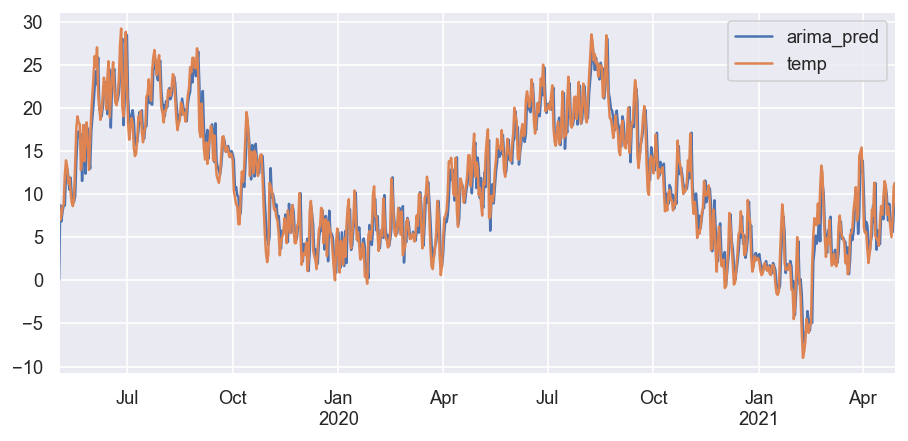

In [144]:
df_2019[['arima_pred', 'temp']].plot()

<AxesSubplot:>

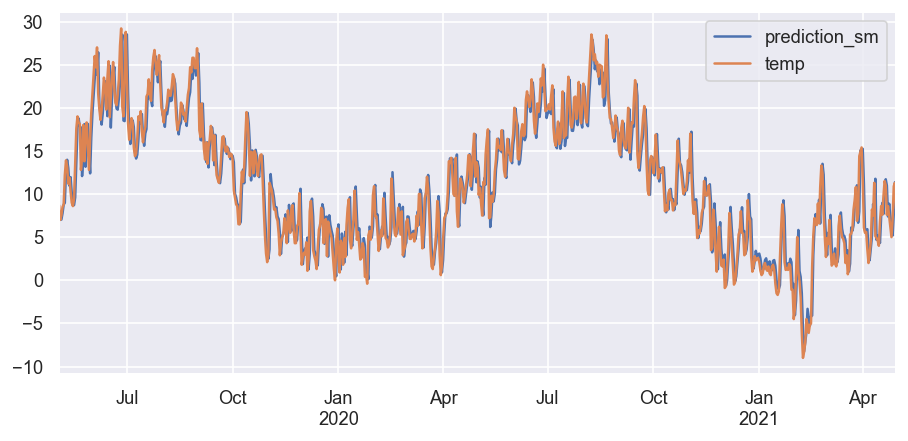

In [145]:
df_2019[['prediction_sm', 'temp']].plot()

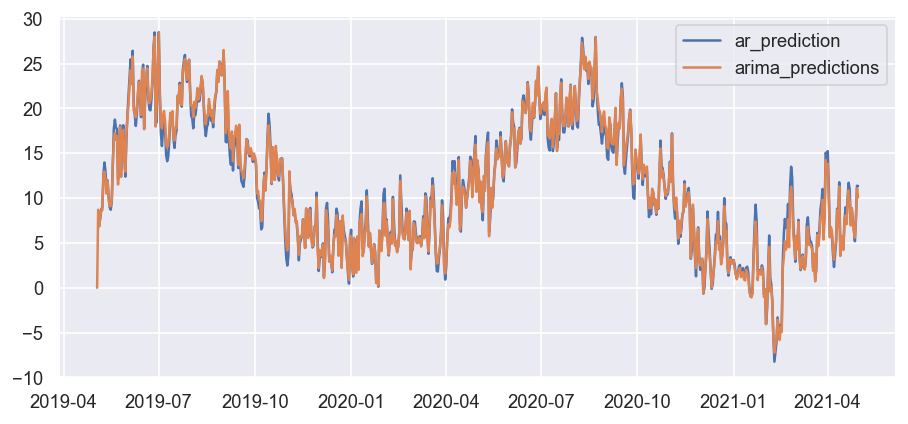

In [146]:
#df_2019[['prediction_sm', 'arima_pred']].plot()
plt.plot(ar_model_2.predict(), label='ar_prediction')
plt.plot(arima_model.predict(), label='arima_predictions')
plt.legend()
plt.show()

In [147]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   temp   No. Observations:                  729
Model:                 ARIMA(2, 1, 4)   Log Likelihood               -1598.756
Date:                Wed, 07 Sep 2022   AIC                           3211.512
Time:                        17:23:28   BIC                           3243.645
Sample:                    05-03-2019   HQIC                          3223.911
                         - 04-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5059      0.185     -2.734      0.006      -0.869      -0.143
ar.L2          0.4119      0.124      3.315      0.001       0.168       0.655
ma.L1          0.5464      0.186      2.938      0.003       0.182       0.911
ma.L2         -0.6889      0.121     -5.689      0.000      -0.926      -0.452
ma.L3         -0.3806      0.083     -4.596      0.000      -0.543      -0.218
ma.L4         -0.0604      0.075     -0.801      0.423      -0.208       0.087
sigma2         4.7285      0.232     20.368      0.000       4.274       5.184
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 9.27
Prob(Q):                              0.99   Prob(JB):                         0.01
Heteroskedasticity (H):               0.94   Skew:                            -0.09
Prob(H) (two-sided):                  0.66   Kurtosis:                         3.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [148]:
ar_model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                   temp   No. Observations:                  729
Model:                     AutoReg(2)   Log Likelihood               -1631.300
Method:               Conditional MLE   S.D. of innovations              2.282
Date:                Wed, 07 Sep 2022   AIC                              1.661
Time:                        17:23:28   BIC                              1.686
Sample:                    05-05-2019   HQIC                             1.671
                         - 04-30-2021                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6177      0.155      3.980      0.000       0.313       0.922
temp.L1        1.0674      0.037     28.974      0.000       0.995       1.140
temp.L2       -0.1215      0.037     -3.299      0.001      -0.194      -0.049
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0663           +0.0000j            1.0663            0.0000
AR.2            7.7183           +0.0000j            7.7183            0.0000
-----------------------------------------------------------------------------
"""

## Cross-validation

## Evaluate on test data

In [149]:
df_test = pd.read_csv('data/temp_test.csv', parse_dates = date)

In [150]:
df_test.dtypes

Unnamed: 0             int64
SOUID                  int64
DATE          datetime64[ns]
TG                     int64
Q_TG                   int64
dtype: object

### Transform test data

In [151]:
df_test= clean_cols(df_test)

In [152]:
df_test= date_to_index(df_test)

In [153]:
df_test = df_test.drop('unnamed: 0', axis = 1)

In [154]:
df_test = date_cols(df_test)

In [155]:
df_test['temp'] = df_test.tg/10

In [156]:
min_date_test = min_date(df_test)

In [157]:
df_test = timestep(df_test)

In [158]:
X, y = X_and_y(df_test)

In [159]:
df_test

,souid,date,tg,q_tg,year,month,weekday,day,temp,timestep
date,,,,,,,,,,
2021-05-01,111448,2021-05-01,92,0,2021,5,5,1,9.2,0
2021-05-02,111448,2021-05-02,81,0,2021,5,6,2,8.1,1
2021-05-03,111448,2021-05-03,74,0,2021,5,0,3,7.4,2
2021-05-04,111448,2021-05-04,101,0,2021,5,1,4,10.1,3
2021-05-05,111448,2021-05-05,88,0,2021,5,2,5,8.8,4
...,...,...,...,...,...,...,...,...,...,...
2022-04-26,111448,2022-04-26,115,0,2022,4,1,26,11.5,360
2022-04-27,111448,2022-04-27,121,0,2022,4,2,27,12.1,361
2022-04-28,111448,2022-04-28,115,0,2022,4,3,28,11.5,362


In [160]:
m = LinearRegression()
m.fit(X, y)

LinearRegression()

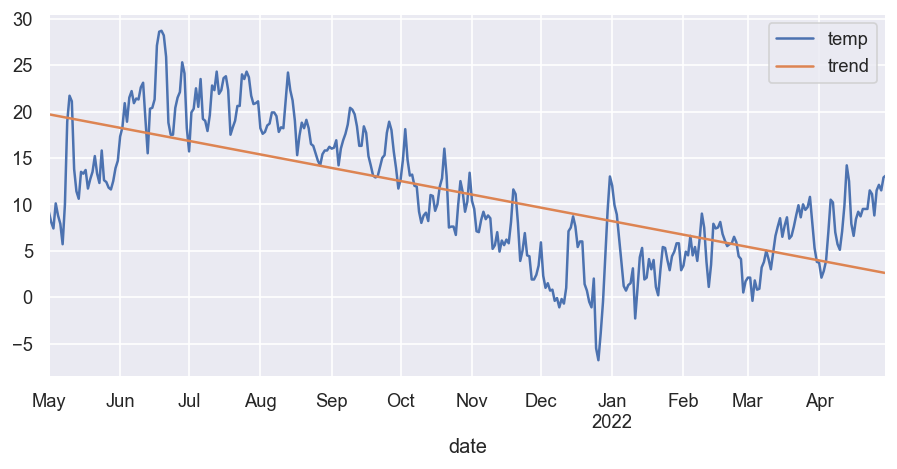

In [161]:
df_test= pred_trend(df_test, X)

In [162]:
min_date_test = min_date(df_test)

In [163]:
print(min_date_test)

2021-05-01


In [164]:
df_test

,souid,date,tg,q_tg,year,month,weekday,day,temp,timestep,trend
date,,,,,,,,,,,
2021-05-01,111448,2021-05-01,92,0,2021,5,5,1,9.2,0,19.699165
2021-05-02,111448,2021-05-02,81,0,2021,5,6,2,8.1,1,19.652160
2021-05-03,111448,2021-05-03,74,0,2021,5,0,3,7.4,2,19.605156
2021-05-04,111448,2021-05-04,101,0,2021,5,1,4,10.1,3,19.558152
2021-05-05,111448,2021-05-05,88,0,2021,5,2,5,8.8,4,19.511147
...,...,...,...,...,...,...,...,...,...,...,...
2022-04-26,111448,2022-04-26,115,0,2022,4,1,26,11.5,360,2.777620
2022-04-27,111448,2022-04-27,121,0,2022,4,2,27,12.1,361,2.730615
2022-04-28,111448,2022-04-28,115,0,2022,4,3,28,11.5,362,2.683611


In [165]:
X, y = X_and_y(df_test)

In [166]:
df_test = seasonal_dum(df_test)

In [167]:
X = get_X_months(df_test)

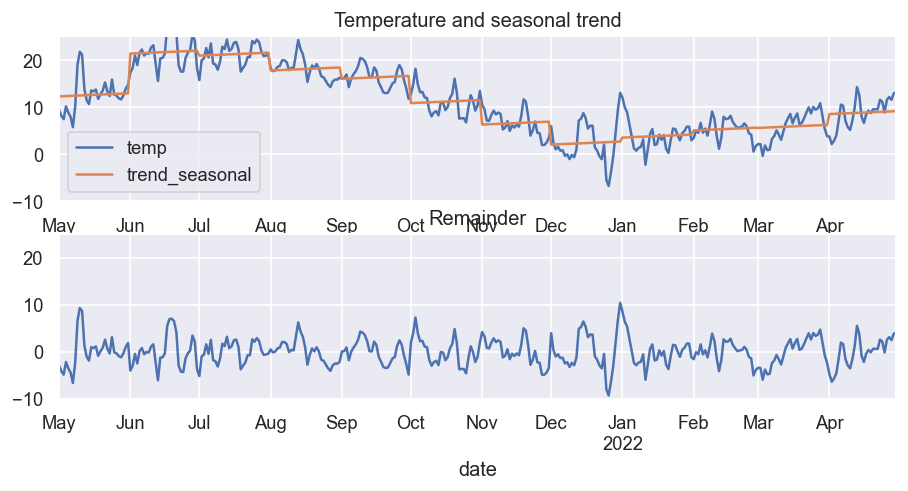

In [168]:
df_test = get_remainder(df_test, '2021-05-01' , plot=True)

In [169]:
'''
def read_csv(df, name):
    df = pd.read_csv(f'data/{name}.csv')
    df.index = pd.to_datetime(df.index)
    print(df.index.dtype)
    return df
'''

"\ndef read_csv(df, name):\n    df = pd.read_csv(f'data/{name}.csv')\n    df.index = pd.to_datetime(df.index)\n    print(df.index.dtype)\n    return df\n"

## Make predictions

### Combine test and train

In [170]:
df_combined = df_post.append(df_test)

In [171]:
df_combined.tail(3)

,souid,date,tg,q_tg,year,month,weekday,day,temp,timestep,...,month_10,month_11,month_12,trend_seasonal,remainder,lag1,full_model,remainder_full_model,pred_var,prediction_sm
2022-04-28,111448,2022-04-28 00:00:00,115.0,0,2022,4,3,28,11.5,362,...,0,0,0,9.048953,2.451047,NaN,NaN,NaN,NaN,NaN
2022-04-29,111448,2022-04-29 00:00:00,129.0,0,2022,4,4,29,12.9,363,...,0,0,0,9.070203,3.829797,NaN,NaN,NaN,NaN,NaN
2022-04-30,111448,2022-04-30 00:00:00,131.0,0,2022,4,5,30,13.1,364,...,0,0,0,9.091453,4.008547,NaN,NaN,NaN,NaN,NaN


### Create lags

In [172]:
df_combined['lag1'] = df_combined['remainder'].shift(1)
df_combined['lag2'] = df_combined['remainder'].shift(2)
df_combined['lag3'] = df_combined['remainder'].shift(3)

In [173]:
df_combined.tail(5)

,souid,date,tg,q_tg,year,month,weekday,day,temp,timestep,...,month_12,trend_seasonal,remainder,lag1,full_model,remainder_full_model,pred_var,prediction_sm,lag2,lag3
2022-04-26,111448,2022-04-26 00:00:00,115.0,0,2022,4,1,26,11.5,360,...,0,9.006454,2.493546,-0.185205,NaN,NaN,NaN,NaN,2.136045,2.557295
2022-04-27,111448,2022-04-27 00:00:00,121.0,0,2022,4,2,27,12.1,361,...,0,9.027704,3.072296,2.493546,NaN,NaN,NaN,NaN,-0.185205,2.136045
2022-04-28,111448,2022-04-28 00:00:00,115.0,0,2022,4,3,28,11.5,362,...,0,9.048953,2.451047,3.072296,NaN,NaN,NaN,NaN,2.493546,-0.185205
2022-04-29,111448,2022-04-29 00:00:00,129.0,0,2022,4,4,29,12.9,363,...,0,9.070203,3.829797,2.451047,NaN,NaN,NaN,NaN,3.072296,2.493546
2022-04-30,111448,2022-04-30 00:00:00,131.0,0,2022,4,5,30,13.1,364,...,0,9.091453,4.008547,3.829797,NaN,NaN,NaN,NaN,2.451047,3.072296


In [174]:
# Re-train the model on the whole dataset
X_combined = df_combined.drop(columns=['tg', 'temp', 'q_tg', 'month', 'weekday', 'year', 'day', 'date', 'souid', 'trend_seasonal', 'remainder', 'trend', 'remainder_full_model', 'full_model', 'pred_var', 'prediction_sm', 'lag2', 'lag3'])
y_combined = df_combined['temp']

#X_full = df.drop(['tg', 'temp', 'q_tg', 'month', 'weekday', 'year', 'day', 'date', 'souid', 'trend_seasonal', 'remainder', 'trend'], axis=1

In [175]:
df_combined.dropna(inplace=True)

In [176]:
X_combined.head(2)

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
1946-01-02,2,0,0,0,0,0,0,0,0,0,0,0,NaN
1946-01-03,3,0,0,0,0,0,0,0,0,0,0,0,-2.526394


In [177]:
max(df_combined.index)

Timestamp('2021-04-30 00:00:00')

In [178]:
months = [0] * 11
lag = df_combined.loc['2021-04-30', 'remainder']
timestep = df_combined['timestep'].max() + 1

In [179]:
# Create a future data point
X_future1 = []
X_future1.append(timestep)
X_future1.extend(months)
X_future1.append(lag)

In [180]:
X_future1

[27515, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.20671342261524828]

In [181]:
y_combined

1946-01-02    -3.0
1946-01-03    -2.8
1946-01-04    -2.7
1946-01-05     1.4
1946-01-06     1.9
              ... 
2022-04-26    11.5
2022-04-27    12.1
2022-04-28    11.5
2022-04-29    12.9
2022-04-30    13.1
Name: temp, Length: 27878, dtype: float64

In [182]:
X_future1 = pd.DataFrame([X_future1], columns = X_combined.columns)

In [183]:
X_future1

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
0,27515,0,0,0,0,0,0,0,0,0,0,0,-0.206713


In [184]:
m_combined = LinearRegression()

In [186]:
#m_combined.fit(X_combined, y_combined)

In [189]:
#y_future1 = m_combined.predict(X_future1)

In [190]:
#flights_future[['passengers', 'trend_seasonal', 'full_model']].plot()